In [ ]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'civic-boulder-370718' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=civic-boulder-370718:US:bquxjob_6c9f476_18c2e7bd8ee)
back to BigQuery to edit the query within the BigQuery user interface.

In [ ]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_6c9f476_18c2e7bd8ee') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT
  DISTINCT driver_id,
  driver_onboard_date,
  MAX(DATE(timestamp)) OVER (PARTITION BY driver_id) AS last_active_date,
  SUM(ride_distince_in_miles) OVER (PARTITION BY driver_id) AS total_miles,
  SUM(ride_duration_in_mins) OVER (PARTITION BY driver_id) AS total_mins,
  active_days,
  total_revenue,
  revenue_per_day
FROM
  `civic-boulder-370718.Lyft_Case.final_table_with_revenue`


# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [ ]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_6c9f476_18c2e7bd8ee') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results

,driver_id,driver_onboard_date,last_active_date,total_miles,total_mins,active_days,total_revenue,revenue_per_day
0,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12 00:00:00+00:00,2016-06-12,762.894459,2535.833333,61,478.421198,7.842970
1,12933735316b452a5bc6a933d1a38124,2016-04-26 00:00:00+00:00,2016-06-26,8986.882559,33558.750000,61,6765.904004,110.916459
2,6b65c06851e944351dd285a1eb729499,2016-05-08 00:00:00+00:00,2016-06-26,15811.294619,52433.583333,49,11053.243249,225.576393
3,d9ef4b835e202c9b24315b999894362a,2016-05-01 00:00:00+00:00,2016-06-26,2683.427946,6232.833333,56,1267.332712,22.630941
4,2f3773bd9dab0fa3e04c6f58dc0714a4,2016-04-22 00:00:00+00:00,2016-06-22,435.829619,1267.833333,61,312.437681,5.121929
...,...,...,...,...,...,...,...,...
832,80f8e8eb5eac6dd41259ccc73993aff6,2016-05-07 00:00:00+00:00,2016-06-23,745.446361,1946.083333,47,456.842997,9.720064
833,e0a98706329350c48ea450d1705bdd86,2016-04-04 00:00:00+00:00,2016-06-26,11359.690249,33446.666667,83,6472.744667,77.984876
834,6a4c652f46bc14c1c04eff3c67cabac0,2016-05-10 00:00:00+00:00,2016-06-23,2008.463697,4814.916667,44,1138.698381,25.879509
835,6cb35e276085548f3f095a85aa63af7b,2016-05-10 00:00:00+00:00,2016-06-08,571.008880,2238.750000,29,478.760076,16.508968


## Show descriptive statistics using describe()
Use the ```pandas DataFrame.describe()```
[method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)
to generate descriptive statistics. Descriptive statistics include those that
summarize the central tendency, dispersion and shape of a dataset’s
distribution, excluding ```NaN``` values. You may also use other Python methods
to interact with your data.

In [ ]:
results.describe()

,total_miles,total_mins,active_days,total_revenue,revenue_per_day
count,837.000000,837.000000,837.0,837.000000,837.000000
mean,4748.873954,15770.215552,55.105137,3046.719716,55.092776
std,3914.427180,12834.110969,21.726518,2473.993861,42.107598
min,30.742330,142.666667,1.0,25.691305,0.570382
25%,1053.267341,3196.916667,42.0,628.586675,19.225604
50%,4509.255172,15825.500000,57.0,3032.228402,48.989803
75%,7182.570304,24008.083333,73.0,4568.841818,77.984876
max,20592.859418,64983.083333,90.0,12641.278258,424.439822


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
results['driver_onboard_date'] = pd.to_datetime(results['driver_onboard_date'])
results['last_active_date'] = pd.to_datetime(results['last_active_date'])


In [ ]:
# Define churn
current_date = results['last_active_date'].max()
results['is_churned'] = results['last_active_date'].apply(lambda x: 1 if (current_date - x).days > 14 else 0)

# Calculate churn rate
churn_rate = results['is_churned'].mean()
print(f"Churn Rate: {churn_rate}")


Churn Rate: 0.3070489844683393


In [ ]:
average_revenue_per_driver = results['total_revenue'].mean()
ltv_method1 = average_revenue_per_driver / churn_rate
ltv_method1


9922.585221840181

In [ ]:
average_revenue_per_day = results['revenue_per_day'].mean()
average_active_days = results['active_days'].mean()
ltv_method2 = average_revenue_per_day * average_active_days
ltv_method2

3035.8950114147387

<ipython-input-11-b4c054d1cba9>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_ltv = results.corr()['LTV']
<ipython-input-11-b4c054d1cba9>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(results.corr(), annot=True, fmt=".2f")


total_miles        0.976777
total_mins         0.994158
active_days        0.522899
total_revenue      1.000000
revenue_per_day    0.743485
is_churned        -0.523628
LTV                1.000000
Name: LTV, dtype: float64


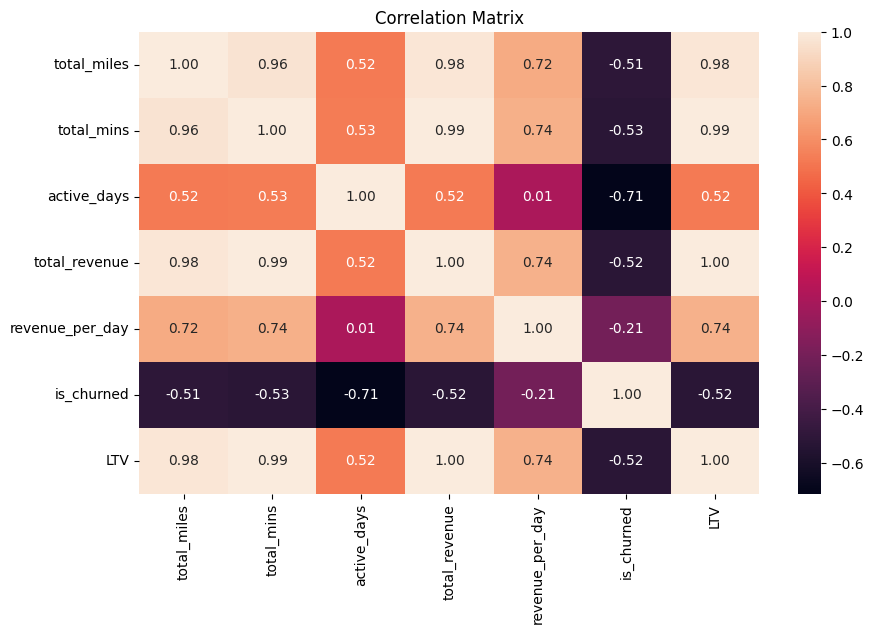

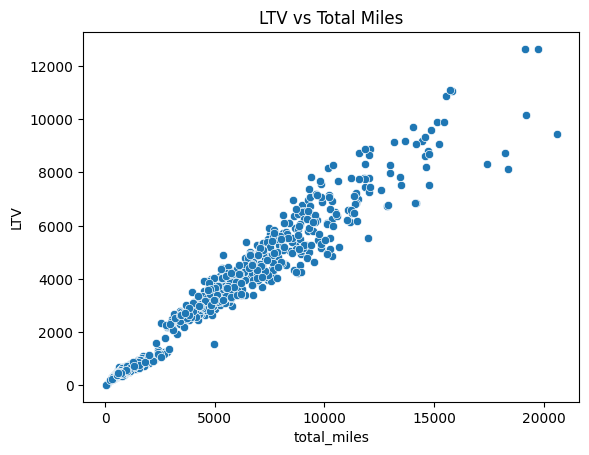

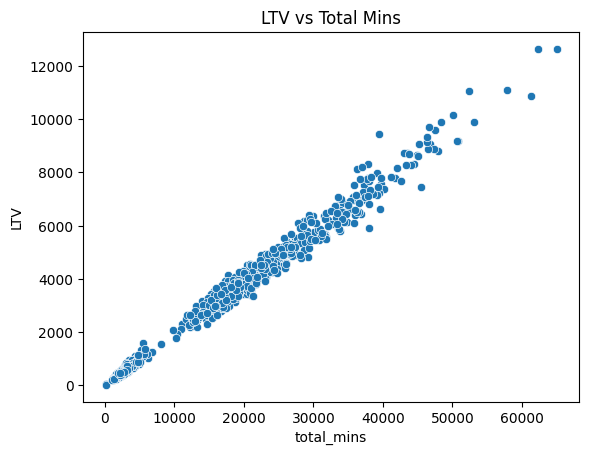

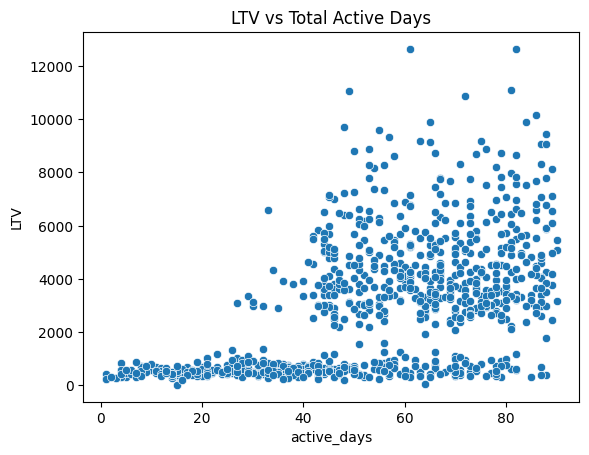

In [ ]:
# Add a column for LTV using Method 2
results['LTV'] = results['revenue_per_day'] * results['active_days']

# Correlation analysis with LTV
correlation_with_ltv = results.corr()['LTV']
print(correlation_with_ltv)

# Visualizing correlations
plt.figure(figsize=(10, 6))
sns.heatmap(results.corr(), annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Visualizations of individual relationships
sns.scatterplot(data=results, x='total_miles', y='LTV')
plt.title("LTV vs Total Miles")
plt.show()

sns.scatterplot(data=results, x='total_mins', y='LTV')
plt.title("LTV vs Total Mins")
plt.show()

sns.scatterplot(data=results, x='active_days', y='LTV')
plt.title("LTV vs Total Active Days")
plt.show()
